# Lindblad master equation

$\partial_{t}\rho = -\frac{i}{\hbar}[H,\rho] + \sum \gamma_{i}(L_{i}\rho L_{i}^{+}-\frac{1}{2}(L_{i}L_{i}^{+}\rho + \rho L_{i}L_{i}^{+}))$

# Quantum jump Monte Carlo(QJMC)

$H_{eff} = H - H_{d} = H - \frac{i\hbar}{2}\sum \gamma_{i}L_{i}^{+}L_{i}$

$\delta p = \delta t\bra{\phi(t)}\frac{i}{\hbar}(H_{eff}-H^{\dagger}_{eff}) \ket{\phi(t)}= \delta t\bra{\phi(t)}\sum\gamma_{i}L_{i}^{+}L_{i}\ket{\phi(t)}$, or equivalently

$\delta p =\delta t \cdot tr[\rho\cdot(\sum\gamma_{i}L_{i}^{+}L_{i})] = \sum \delta t\gamma_{i}tr(\rho L_{i}^{+}L_{i}) = \sum\delta p_{i}$

More briefly, total jump probability

$\delta p =-2i \delta t \cdot tr[\rho\cdot H_{d}]$

If random number r > $\delta p$, evolve the state:

$\ket{\phi(t+\delta t)}= \sqrt{\frac{1}{1-\delta p}}(I-\frac{i}{\hbar}H_{eff}\delta t)\ket{\phi(t)}$

If random number r < $\delta p$, apply jump(with probability $\pi_{i}=\frac{\delta p_{i}}{\delta p}$, choose $L_{i}$)

$\ket{\phi(t+\delta t)}= \sqrt{\gamma_{i}\frac{\delta t}{\delta p_{i}}} L_{i}\ket{\phi(t)}$

We can also build the density matrix,

$\ket{\phi(t+\delta t)}\bra{\phi(t+\delta t)} = \gamma_{i}\frac{\delta t}{\delta p_{i}} L_{i}\ket{\phi(t)}\bra{\phi(t)}L^{\dagger}_{i}$

$\ket{\phi(t+\delta t)}\bra{\phi(t+\delta t)} = \frac{1}{1-\delta p}(I-iH_{eff}\delta t)\ket{\phi(t)}\bra{\phi(t)}(I+iH^{\dagger}_{eff}\delta t)$

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm

Pauli matrices are what we need here to construct H and L's. We first define them in one- and two-body Hilbert space. 

In [118]:
# Define Pauli matrices
identity = np.eye(2, dtype = complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_plus =  np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)


# List of one- and two-body operators O 
# O[n-1][m-1] : n-body operators, m-th particle operator
id = [[identity], [np.kron(identity, identity)]]
S_x = [[sigma_x], [np.kron(sigma_x, identity), np.kron(identity, sigma_x)]]
S_plus = [[sigma_plus], [np.kron(sigma_plus, identity), np.kron(identity, sigma_plus)]]
S_minus = [[sigma_minus], [np.kron(sigma_minus, identity), np.kron(identity, sigma_minus)]]



Then quantum states

In [306]:
# Define single-particle states |0> <0| and |1> <1|
rho_gg = np.array([[1, 0], [0, 0]], dtype=complex)
rho_ee = np.array([[0, 0], [0, 1]], dtype=complex)

# List of one- and two-body density matrices rho[n-1][m-1]: n-body density matrix, m-th particle excited
rho_g = [[rho_gg], [np.kron(rho_gg,rho_gg)]]
rho_e = [[rho_ee], [np.kron(rho_ee, 1/2*identity), np.kron(1/2*identity, rho_ee)]]

print(np.trace(rho_e[1][0] @ (1/2* rho_e[1][1]+1/2* rho_g[1][0])))
print(np.trace(rho_e[1][1] @ (1/2* rho_e[1][1]+1/2* rho_g[1][0])))


(0.125+0j)
(0.25+0j)


Now define the function to build the non-Hermitian Hamiltonian

In [145]:
# Input: (2^n x 2^n matrix)
# Output: (2^n x 2^n matrix)
def dagger(matrix):
    return np.conj(matrix).T

# Input: (2^n x 2^n matrix), (list of 2^n x 2^n matrix), (list of values)
# Output: (2^n x 2^n matrix), (2^n x 2^n matrix), (2^n x 2^n matrix)
def effective_Hamiltonian(H, L_ops, gamma_values):
    
    # Check the system size
    n = len(gamma_values)
    
    # Dissipator
    H_d = np.zeros((2 ** n, 2 ** n), dtype = complex)
    for gamma, L in zip(gamma_values, L_ops):
        L_dagger = dagger(L)
        H_d += 1j/2 * gamma * L_dagger @ L
             
    # Non-Hermitian Hamiltonian
    H_eff = H -  H_d
    H_eff_dagger = dagger(H_eff)
    
    return H_eff, H_eff_dagger, H_d

Then, build a function which can calculate $\delta p = \sum \delta p_{i}$ and pick a $L_{i}$ according to the relative probability $\delta p_{i}$.

In [209]:
# Input: quantum states(2^n x 2^n matrix), jump operators L(list of 2^n x 2^n matrix)
# decay rate(list of values), dt(value)
# Output: jump probability(value), chosen_gamma(value), 
# chosen L(2^n x 2^n matrix), chosen_dp(value)
def quantum_jump_probabilities(rho, L_ops, gamma_values, dt):
    dp_values = []
    
    for gamma, L in zip(gamma_values, L_ops):
        L_dagger = dagger(L)
        
        # Compute gamma_i * trace(rho * L^+_i * L_i)
        jump_prob = dt * gamma * np.trace(rho @ L_dagger @ L)
        jump_prob = np.real(jump_prob)
        dp_values.append(jump_prob)
        
    # calculate dp and list of normalized dp_i
    total_prob = np.sum(dp_values)
    if total_prob != 0:
        normalized_dp = [x / total_prob for x in dp_values]
        # Pick gamma_i and L_i
        chosen_index = np.random.choice(len(L_ops), p=normalized_dp)
        chosen_gamma = gamma_values[chosen_index]
        chosen_L = L_ops[chosen_index]
        chosen_dp = dp_values[chosen_index]
    else:
        normalized_dp = chosen_gamma = chosen_L = chosen_dp = None  
      

    return total_prob, chosen_gamma, chosen_L, chosen_dp

# Test case
rho = rho_e[0][0]
L_ops = [S_minus[0][0]]  
gamma_values = [5]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(rho, L_ops, gamma_values, dt)

    print("Total Jump Probability:", dp_data)

rho = rho_g[0][0]
L_ops = [S_minus[0][0]]  
gamma_values = [5]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(rho, L_ops, gamma_values, dt)

    print("Total Jump Probability:", dp_data)




Total Jump Probability: (0.0, None, None, None)
Total Jump Probability: (0.005, 5, array([[0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j]]), 0.005)


Then, build a function to simulate trajectories of n particles(or n modes).

In [307]:
# Input : initial state(2^n x 2^n matrix), Hamiltonian(2^n x 2^n matrix),
# jumps(list of 2^n x 2^n matrices), decay rate(list of values), total_time(value), dt(value)

# Output[0] : time-evolved states(list of 2^n x 2^n matrix) 
# Output[1][n-1][t-1] : time-evolved excitation density of n-th particle(list of values)
def single_simulation(rho, H, L_ops, gamma_values, total_time, dt):
    
    # Check the system size
    n = len(gamma_values)
    
    # Prepare the storage for quantum_states[t] : density matrix at time t
    states_ops = [] 
    
    # Prepare the storage for excitation_density[n-1][t] : nth particle's excitation density at time t 
    n_e_values = [[] for _ in range(n)] 

    # Set up initial state Rho(t=0) 
    current_time = 0
    current_state = rho

    # Counting jumps
    jump_num = 0

             
    # Set-up non-Hermitian Hamiltonian
    H_eff, H_eff_dagger, H_d = effective_Hamiltonian(H, L_ops, gamma_values)
    
    # Evolve the state
    while current_time < total_time:
        
        # record current quantum state
        states_ops.append(current_state)
        
        # record current excitation density
        for i in range(n):
            n_e = np.trace(rho_e[n-1][i] @ current_state)
            n_e_values[i].append(n_e)

        # calculate jump probability, pick a jump operator along with its gamma and dp 
        dp_data = quantum_jump_probabilities(current_state, L_ops, gamma_values, dt)
        dp_total = dp_data[0]
        chosen_gamma = dp_data[1]
        chosen_L = dp_data[2]
        chosen_dp = dp_data[3]
        
        # check jump condition
        jump_occurs = np.random.rand() < dp_total

        # Propagate the state 
        if jump_occurs:
            jump_num += 1
            current_state = dt/chosen_dp * chosen_gamma * chosen_L @ current_state @ dagger(chosen_L)
        else:
            current_state = (id[n-1][0] - 1j * dt * H_eff) @ current_state @ (id[n-1][0] + 1j * dt * H_eff_dagger)
        
        # update time
        current_time += dt
        
    
    return states_ops, n_e_values


# Define multiple simulation function
# Output[0][m-1][t-1] : quantum states at time t in m-th trajectory
# Output[1][m-1][n-1][t-1] : n-th particle's excited density at time t in m-th trajectory
def multiple_simulations(N, rho, H, L_ops, gamma_values, total_time, dt):

    # Prepare storage for data from every single simulation
    states_ops = []
    n_e_values = []

    for _ in range(N):
        
        single_simulation_result = single_simulation(rho, H, L_ops, gamma_values, total_time, dt)

        states_ops.append(single_simulation_result[0])
        n_e_values.append(single_simulation_result[1])

    return states_ops, n_e_values



# Exercises : Two level system

Master equation: 

$\partial_{t}\rho = -i[\Omega\sigma^{x},\rho] + \gamma(\sigma^{-}\rho\sigma^{+}- \frac{1}{2}(\sigma^{+}\sigma^{-}\rho+\rho\sigma^{+}\sigma^{-}))$

This is the Lindbladian form with

$H = \Omega\sigma^{x}$, $L^{\dagger}_i = L^{\dagger} = \sigma^{+}$, $L_i = L = \sigma^{-}$

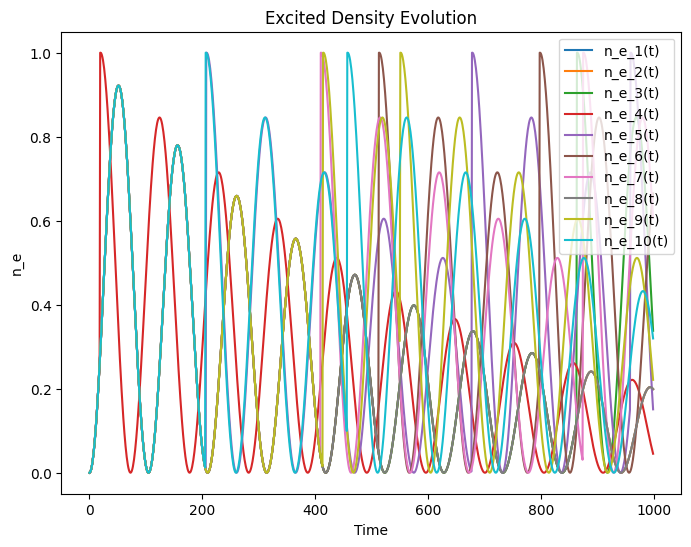

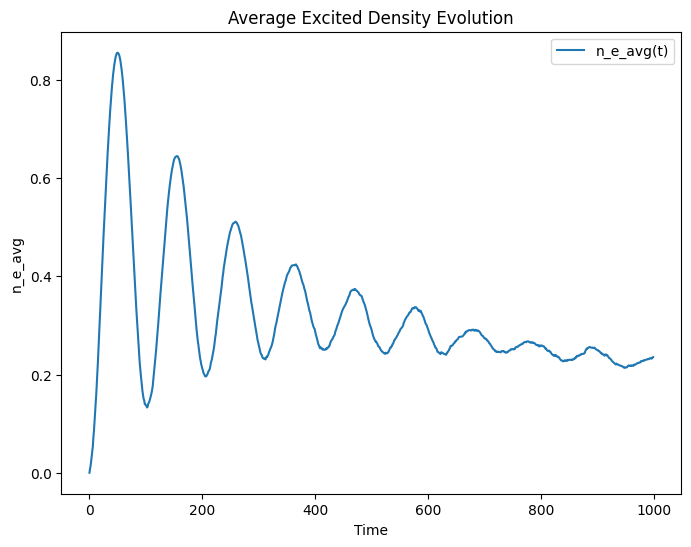

In [338]:
# Define Hamiltonian, jump operators of the two level system (let hbar=1)
omega = 30
rho = rho_g[0][0]
H = omega * S_x[0][0]
L_ops = [S_minus[0][0]]
gamma_values = [5]
total_time = 1.0
dt = 0.001

# Multiple simulations of trajectory
N = 1000
states, n_e = multiple_simulations(N, rho, H, L_ops, gamma_values, total_time, dt)

# Average the excitation density over trajectories
n_e_array = []
sum = np.zeros(np.shape(n_e[0][0]),dtype = complex)

for i in range(N):
    n_e_array.append(np.array(n_e[i][0]))
    sum += n_e[i][0]
    
n_e_avg_array = np.array(sum/N)

# Plot the results
plt.figure(figsize=(8,6))

for i in range(10):
    plt.plot(n_e_array[i], label=f'n_e_{i + 1}(t)')
    
plt.title('Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(n_e_avg_array, label='n_e_avg(t)')
plt.title('Average Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e_avg')
plt.legend()
plt.show()


# Compared to the analytic method

Solve the eigenvalues and eigenvectors of the superoperator 

$L[\rho]=-i[\Omega\sigma^{x},\rho] + \gamma(\sigma^{-}\rho\sigma^{+}- \frac{1}{2}(\sigma^{+}\sigma^{-}\rho+\rho\sigma^{+}\sigma^{-}))$ 

whose matrix representation is 

$
\begin{pmatrix}
    0 & i\Omega & -i\Omega & \gamma\\
    i\Omega & \frac{\gamma}{2} & 0 & -i\Omega\\
    -i\Omega & 0 & -\frac{\gamma}{2} & i\Omega\\
    0 & -i\Omega & i\Omega & 0\\
\end{pmatrix}
\begin{pmatrix}
    \rho_{gg} \\
    \rho_{ge} \\
    \rho_{eg} \\
    \rho_{ee} \\
\end{pmatrix} = \lambda 
\begin{pmatrix}
    \rho_{gg} \\
    \rho_{ge} \\
    \rho_{eg} \\
    \rho_{ee} \\
\end{pmatrix}
$

$\rho(t) = \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ where $\hspace{2em} c_{i} =u^{\dagger}_{i}\rho(0)\hspace{2em}$ 

The initial state we chose is $\hspace{1em}  \mathbf{\rho(t=0)} = \begin{pmatrix}
    1 \\
    0 \\
    0 \\
    0 \\
\end{pmatrix}\hspace{1em}$

(0.5021454297888974-1.8503717077081104e-18j)
(0.2079593130446919-0.020530520188640294j)
(1.2062542493284034+0.020530520188640225j)
(-0.49700680800094205-0.041168018164049816j)


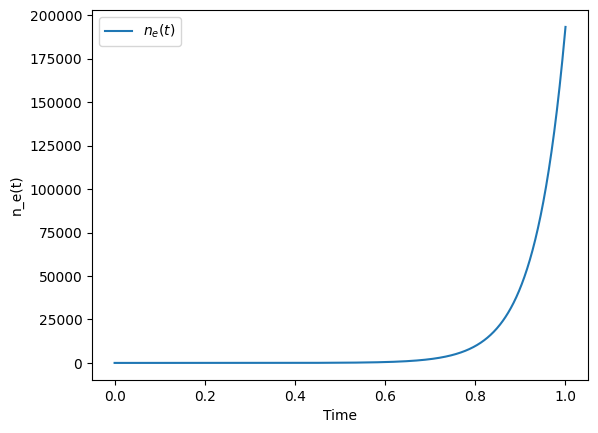

In [391]:
# Define the matrix
Omega = 30
gamma = 5

superL = np.array([
    [0, 1j*Omega, -1j*Omega, gamma],
    [1j*Omega, -gamma/2, 0, -1j*Omega],
    [-1j*Omega, 0, -gamma/2, 1j*Omega],
    [0, -1j*Omega, 1j*Omega, 0]
])

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(superL)

# Eigenvalues
lambda1 = eigenvalues[0]
lambda2 = eigenvalues[1]
lambda3 = eigenvalues[2]
lambda4 = eigenvalues[3]
# Eigenvectors
u1 = eigenvectors[0]
u2 = eigenvectors[1]
u3 = eigenvectors[2]
u4 = eigenvectors[3]

# Normalize the vector by letting rho_gg + rho_ee = 1
print(u1[0] + u1[3])
print(u2[0] + u2[3])
print(u3[0] + u3[3])
print(u4[0] + u4[3])


# Initial state
rho_0 = np.array([1, 0, 0, 0])
# Excited state
rho_1 = np.array([0, 0, 0, 1])

# Coefficients of the solution: c1, c2, c3, c4
c1 = dagger(eigenvectors[0])@ rho_0
c2 = dagger(eigenvectors[1])@ rho_0
c3 = dagger(eigenvectors[2])@ rho_0
c4 = dagger(eigenvectors[3])@ rho_0



parameters = [c1, c2, c3, c4, lambda1, lambda2, lambda3, lambda4, u1, u2, u3, u4]

# Construct the solution rho(t) of the master equation
def Rho(parameters, t):
    return parameters[0]*np.exp(parameters[4]*t)*parameters[8] + parameters[1]*np.exp(parameters[5]*t)*parameters[9] + parameters[2]*np.exp(parameters[6]*t)*parameters[10] + parameters[3]*np.exp(parameters[7]*t)*parameters[11]


t_values = np.linspace(0, 3, 1000)

ne = []
for t in t_values:
    ne.append(np.abs(Rho(parameters, t)[0])**2)

# Plot
t_values = np.linspace(0, 1, 1000)
n_e_values = np.array(ne)
plt.plot(t_values, n_e_values, label=r'$n_e(t)$')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()


$\lambda_{1} = 0 \;, \hspace{13em}
\mathbf{u_{1}} = \begin{pmatrix}
    \frac{i\gamma}{2\omega} \\
    1 \\
    1 \\
    0 \\
\end{pmatrix}
 $

$\lambda_{2} = \frac{\gamma}{2} \;,\hspace{13em} 
\mathbf{u_{2}} = \begin{pmatrix}
    1 \\
    \frac{i\gamma}{2\omega} \\
    0 \\
    1 \\
\end{pmatrix}
 $

$\lambda_{3} = \frac{1}{4}(-\gamma-\sqrt{\gamma^{2}-64\omega^{2}}) \;, \hspace{4em} 
\mathbf{u_{3}} = \begin{pmatrix}
    -\frac{\gamma^{2}+16\omega^{2}-\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}} \\
    -\frac{i(-\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega} \\
    \frac{i(3\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega}\\
    1 \\
\end{pmatrix}
 $

$\lambda_{4} = \frac{1}{4}(-\gamma+\sqrt{\gamma^{2}-64\omega^{2}}) \;, \hspace{4em} 
\mathbf{u_{4}} = \begin{pmatrix}
    -\frac{\gamma^{2}+16\omega^{2}+\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}} \\
    \frac{i(\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega} \\
    -\frac{i(-3\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega}\\
    1 \\
\end{pmatrix}
 $

The initial state we chose is $\hspace{1em}  \mathbf{\rho(t=0)} = \begin{pmatrix}
    1 \\
    0 \\
    0 \\
    0 \\
\end{pmatrix}\hspace{1em}$, with all these we can easily express the solution by

$\rho(t) = \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ where $\hspace{2em} c_{i} =u^{\dagger}_{i}\rho(0)\hspace{2em}$ and list below

$c_{1} = u^{\dagger}_{1}\rho(0)=-\frac{i\gamma}{2\omega} \hspace{2em} c_{2} = u^{\dagger}_{2}\rho(0)=1 \hspace{2em} c_{3} = u^{\dagger}_{3}\rho(0)=(-\frac{\gamma^{2}+16\omega^{2}-\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}})^{*} \hspace{2em} $

$c_{4} = u^{\dagger}_{4}\rho(0)= (-\frac{\gamma^{2}+16\omega^{2}+\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}})^{*}$

The quantity concerns us here is excitation density

$n_{e}(t) = \|\rho^{\dagger}_{e}\rho(t)\|^{2}= \|\begin{pmatrix} 0 & 0 & 0 & 1 \end{pmatrix}(c_{1}e^{\lambda_{1}t}\mathbf{u_{1}}+c_{2}e^{\lambda_{2}t}\mathbf{u_{2}}+c_{3}e^{\lambda_{3}t}\mathbf{u_{3}}+c_{4}e^{\lambda_{4}t}\mathbf{u_{4}}))\|^{2}\hspace{1em}$ which leads us to

$n_{e}(t) = \| \begin{pmatrix} 0 & 0 & 0 & 1 \end{pmatrix} \begin{pmatrix}
    z_{1} \\
    z_{2} \\
    z_{3} \\
    c_{2}e^{\lambda_{2}t}+c_{3}e^{\lambda_{3}t}+c_{4}e^{\lambda_{4}t} \\
\end{pmatrix}\|^{2} = \|c_{2}e^{\lambda_{2}t}+c_{3}e^{\lambda_{3}t}+c_{4}e^{\lambda_{4}t}\|^{2}$

where $z_{1}$, $z_{2}$, $z_{3}$ are known numbers, which can be easily checked, not relevant to our results 

(11.696673496337935+0j)
11.696673496337935


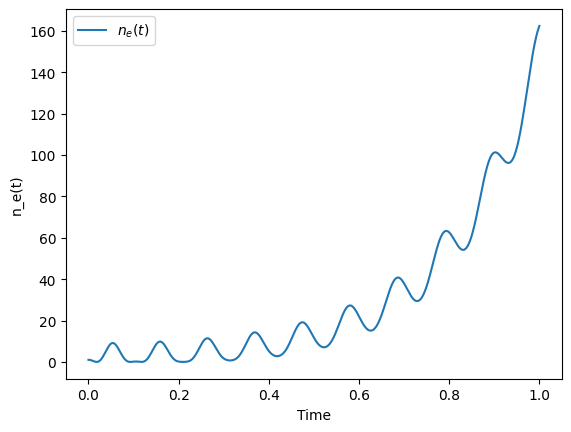

In [347]:
# Draw the result from the analytic method
gamma = 5
omega = 30
lambda2 = gamma / 2
lambda3 = 1/4 * (-gamma - np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
lambda4 = 1/4 * (-gamma + np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
c2 = 1
c3 = np.conj(-(gamma**2 + 16*omega**2 - gamma*np.sqrt(gamma**2 - 64*omega**2, dtype=complex))/(16*omega**2))
c4 = np.conj(-(gamma**2 + 16*omega**2 + gamma*np.sqrt(gamma**2 - 64*omega**2, dtype=complex))/(16*omega**2))
parameters = [c2, c3, c4, lambda2, lambda3, lambda4]


def phi_e(parameters, t):
    return parameters[0] * np.exp(parameters[3] * t) + parameters[1] * np.exp(parameters[4] * t) + parameters[2] * np.exp(parameters[5] * t)



def ne(parameters, t):
    return np.abs(parameters[0] * np.exp(parameters[3] * t) + parameters[1] * np.exp(parameters[4] * t) + parameters[2] * np.exp(parameters[5] * t))**2

print(np.conj(phi_e(parameters, 0.5)) * phi_e(parameters, 0.5))
print(ne(parameters, 0.5))


# Plot
t_values = np.linspace(0, 1, 1000)
n_e_values = np.array(ne)
plt.plot(t_values, n_e_values, label=r'$n_e(t)$')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()
    

# Exercises : Interacting-atom system

Master equation: 

$\partial_{t}\rho = -i[\Omega\sum\sigma^{x}_{k},\rho] + \gamma\sum(\sigma^{-}_{k}\rho\sigma^{+}_{m}- \frac{1}{2}(\sigma^{+}_{k}\sigma^{-}_{m}\rho+\rho\sigma^{+}_{k}\sigma^{-}_{m}))$

Diagonalize $\gamma$ we get the Lindblad form with 

$\gamma_{1} = 0$ and $\gamma_{2} = 2\gamma$

$H = \Omega\sum\sigma^{x}_{k}$ , $L_{1} = \frac{1}{\sqrt{2}}\sigma^{-}_{1}-\frac{1}{\sqrt{2}}\sigma^{-}_{2}$ , and $L_{2} = \frac{1}{\sqrt{2}}\sigma^{-}_{1}+\frac{1}{\sqrt{2}}\sigma^{-}_{2}$

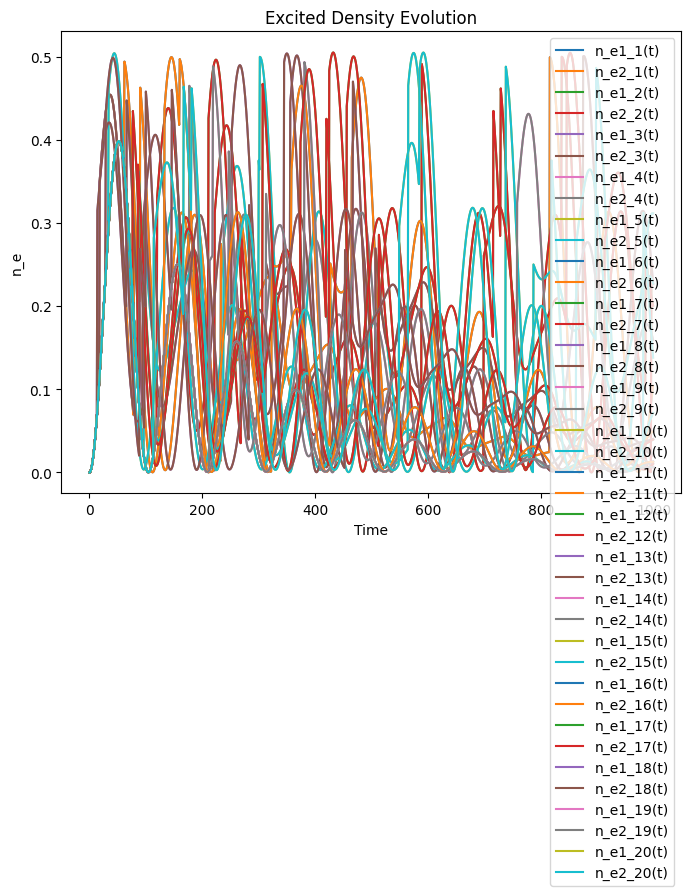

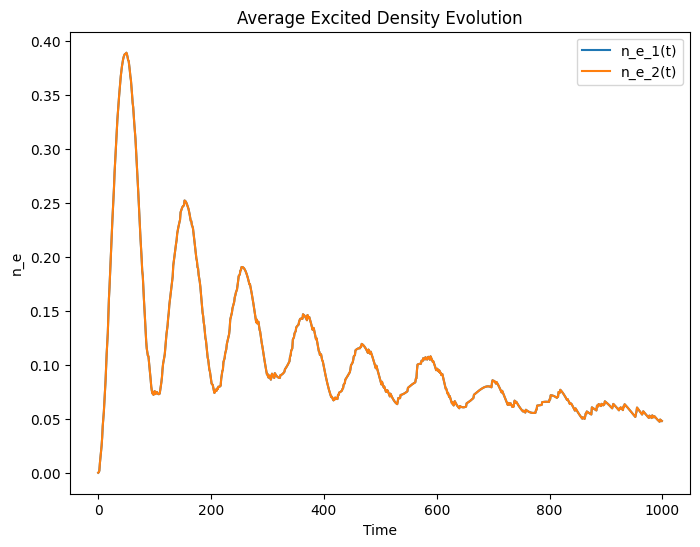

In [333]:
# Define Hamiltonian, jump operators of the interacting-atom system (let hbar=1)
omega = 30
rho = rho_g[1][0]
H = omega * (S_x[1][0]+S_x[1][1]) 
L1 = 1/np.sqrt(2) * (S_minus[1][0] - S_minus[1][1])
L2 = 1/np.sqrt(2) * (S_minus[1][0] + S_minus[1][1])
L_ops = [L1, L2]
gamma_values = [0, 10]
total_time = 1.0
dt = 0.001

# Multiple simulations of trajectory
N = 100
states, n_e = multiple_simulations(N, rho, H, L_ops, gamma_values, total_time, dt)


# Average the excitation density over trajectories
n_e_array1 = []
n_e_array2 = []
sum1 = np.zeros(np.shape(n_e[0][0]),dtype = complex)
sum2 = np.zeros(np.shape(n_e[0][1]),dtype = complex)

for i in range(N):
    n_e_array1.append(np.array(n_e[i][0]))
    n_e_array2.append(np.array(n_e[i][1]))
    sum1 += n_e[i][0]
    sum2 += n_e[i][1]
    
n_e_avg_array1 = np.array(sum1/N)
n_e_avg_array2 = np.array(sum2/N)

# Plot the results
plt.figure(figsize=(8,6))
for i in range(20):
    plt.plot(n_e_array1[i], label=f'n_e1_{i + 1}(t)')
    plt.plot(n_e_array2[i], label=f'n_e2_{i + 1}(t)')
    
plt.title('Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(n_e_avg_array1, label = 'n_e_1(t)')
plt.plot(n_e_avg_array2, label = 'n_e_2(t)')

plt.title('Average Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()
